## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [5]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [6]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


## Inference

In [7]:
model = keras.models.load_model("data/ncbi_02/model_gru_noise_256")
model.summary()

2021-11-12 15:15:28.531447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 15:15:28.532540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 15:15:28.548657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 15:15:28.549474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 15:15:28.550470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, 256), (None, 201216      input_3[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 256)          0           gru_2[0][1]                      
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 4)]    0                                            
____________________________________________________________________________________________

In [8]:
latent_dim = 256

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc = model.layers[1].output  # gru_1
encoder_model = keras.Model(encoder_inputs, state_h_enc)

encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
gru_2 (GRU)                  [(None, 256), (None, 256) 201216    
Total params: 201,216
Trainable params: 201,216
Non-trainable params: 0
_________________________________________________________________


In [9]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape = (latent_dim,))
gaussian_noise = model.layers[2](decoder_state_input_h)
batch_normalization = model.layers[4](gaussian_noise)

decoder_gru = model.layers[5]
decoder_outputs, state_h_dec = decoder_gru(
    decoder_inputs, initial_state = batch_normalization
)

decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [ decoder_inputs, decoder_state_input_h ], [ decoder_outputs, state_h_dec ]
)

decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 256)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        gaussian_noise_1[1][0]           
____________________________________________________________________________________________

In [10]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [32]:
def decode_sequence(input_seq):

    output_seq = np.zeros_like(input_seq)
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(token_index)))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for i in range(encoder_input_data.shape[1]):
        
        output_token, h = decoder_model.predict([ target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_token[0, -1, :])
        output_seq[0, i, sampled_token_index] = 1.0
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(token_index)))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = h
        
    return output_seq

In [33]:
def decode_sequence_batch(input_seqs):
    n_seqs = input_seqs.shape[0]

    output_seqs = np.zeros_like(input_seqs)
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seqs)
    
    # Generate empty target sequence of length 1.
    target_seqs = np.zeros((n_seqs, 1, len(token_index)))
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for i in tqdm(range(encoder_input_data.shape[1])):
        
        output_token, h = decoder_model.predict([ target_seqs, states_value ])

        # Sample a token
        sampled_token_indexes = np.squeeze(np.argmax(output_token, axis = 2))
        output_seqs[:, i, sampled_token_indexes] = 1.0
        
        # Update the target sequence (of length 1).
        target_seqs = np.zeros((n_seqs, 1, len(token_index)))
        target_seqs[:, 0, sampled_token_indexes] = 1.0

        # Update states
        states_value = h

    return output_seqs

In [53]:
rep = np.zeros((100, 3822, 4))
rep[:] = encoder_input_data[0]
rep.shape

(100, 3822, 4)

In [54]:
rep_pred = decode_sequence_batch(rep)
rep_pred.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [01:59<00:00, 32.05it/s]


(100, 3822, 4)

In [13]:
output_seqs = decode_sequence_batch(encoder_input_data)

# with open('data/ncbi_02/predicted_256_gru.npy', 'wb') as f:
#     np.save(f, output_seqs)
    
#     d = keras.losses.CategoricalCrossentropy()(target_seq, output_seq).numpy()
#     print(f"{i}. {d}")

2021-11-12 15:15:44.503165: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 15:15:45.039632: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [11:12<00:00,  5.68it/s]


## Metrics

In [14]:
keras.losses.CategoricalCrossentropy()(decoder_target_data, output_seqs).numpy()

10.750038

In [15]:
cce = []
for i in range(len(decoder_target_data)):
    _ = keras.losses.CategoricalCrossentropy()(decoder_target_data[i:i + 1], output_seqs[i:i + 1]).numpy()
    cce.append(_)
cce = np.array(cce)

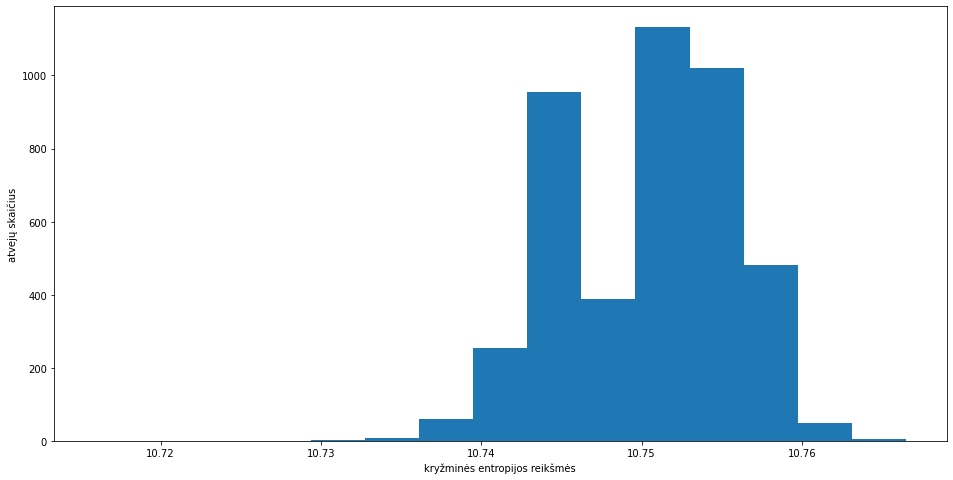

In [16]:
plt.hist(cce, bins = 15)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [17]:
decoder_input_sequences = decode_seq(decoder_input_data)

In [18]:
decoder_target_sequences = decode_seq(decoder_target_data)
decoder_output_sequences = decode_seq(output_seqs)

In [19]:
lev_distances = [ distance(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
lev_ratio = [ ratio(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
ham_distances = [ hamming(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]

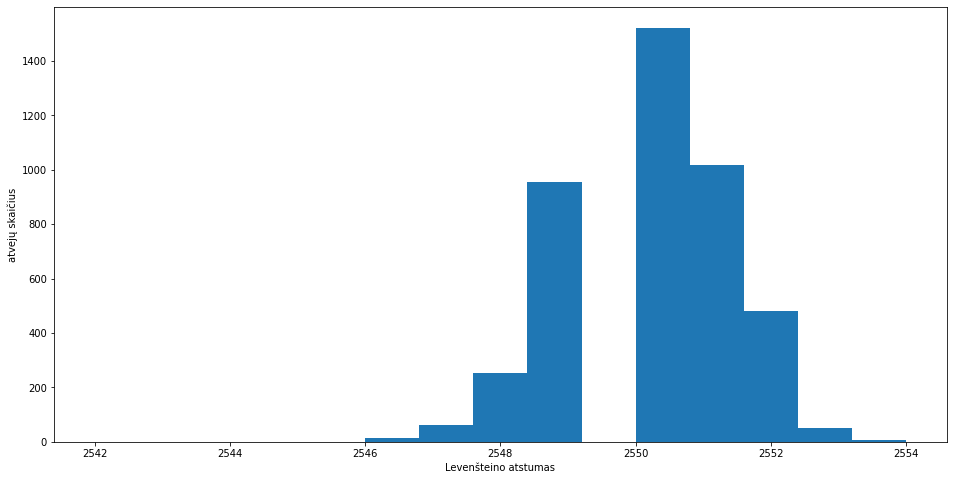

In [20]:
plt.hist(lev_distances, bins = 15)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.show()

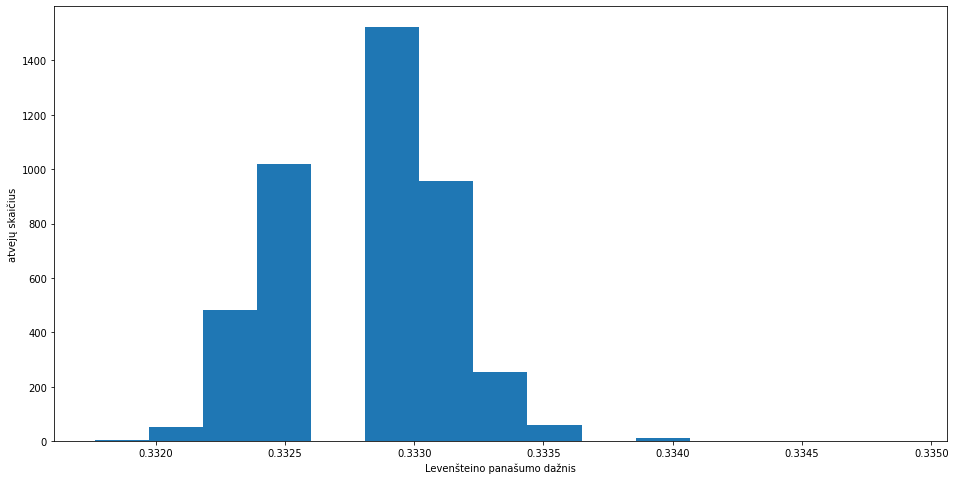

In [21]:
plt.hist(lev_ratio, bins = 15)
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

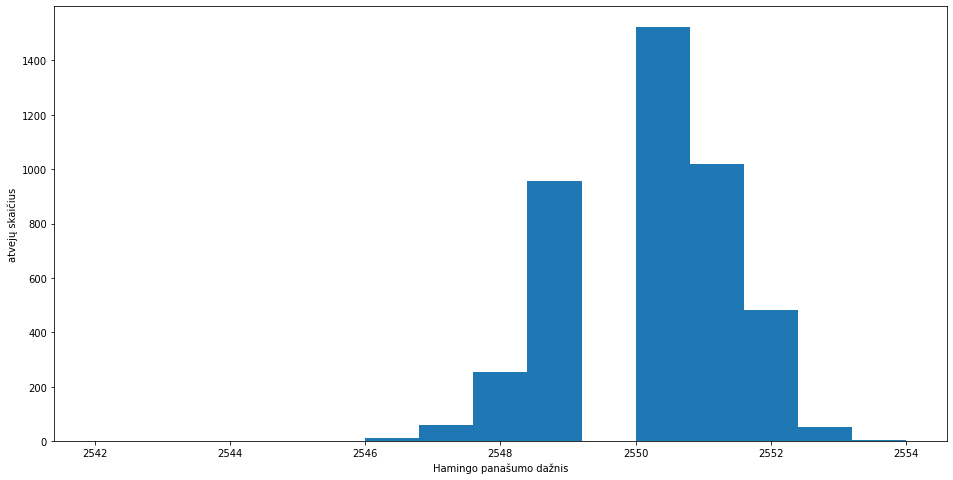

In [22]:
plt.hist(ham_distances, bins = 15)
plt.xlabel('Hamingo panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

In [23]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(encoder_input_data, axis = 2), 
        np.argmax(decoder_input_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [24]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(decoder_target_data, axis = 2), 
        np.argmax(output_seqs, axis = 2)
    ) != 0.0).astype(int), axis = 0)

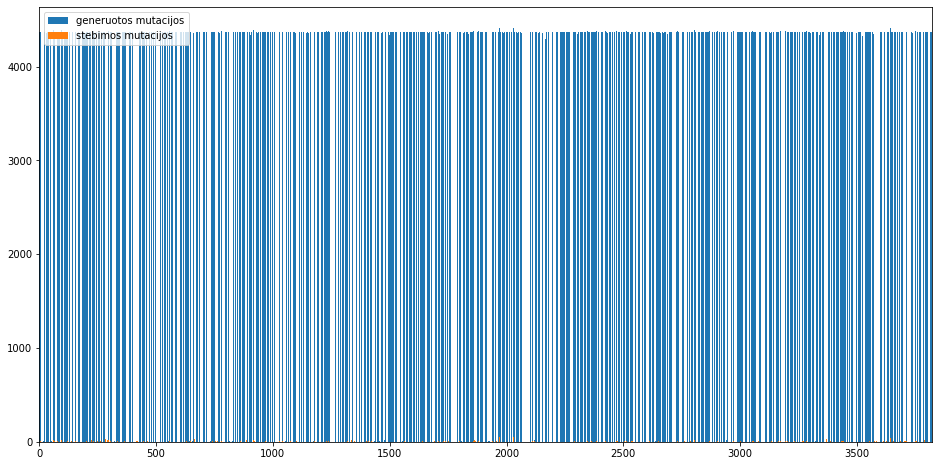

In [25]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.legend()
plt.show()

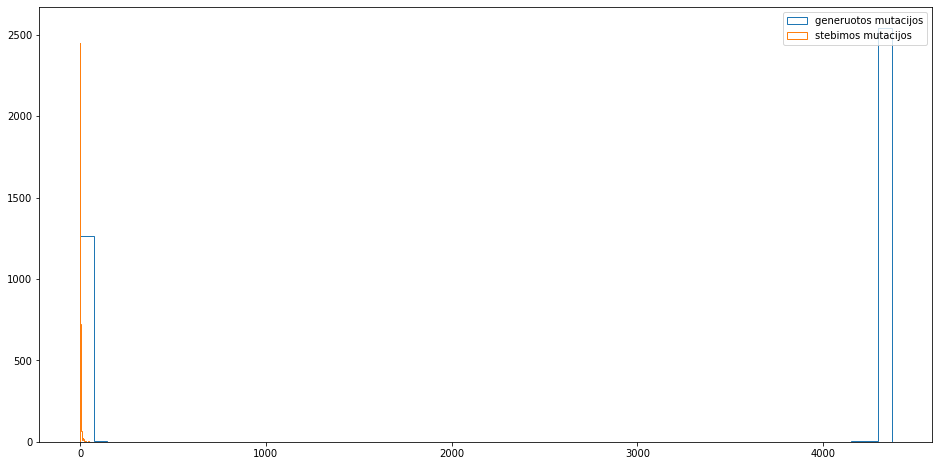

In [26]:
plt.hist(mut02, bins = 60, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 60, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

In [ ]:
decoder_input_sequences[100]

In [ ]:
decoder_target_sequences[100]

In [ ]:
decoder_output_sequences[0]